<div class="align-center">
<a href="https://oumi.ai/"><img src="https://oumi.ai/docs/en/latest/_static/logo/header_logo.png" height="200"></a>

[![Documentation](https://img.shields.io/badge/Documentation-latest-blue.svg)](https://oumi.ai/docs/en/latest/index.html)
[![Discord](https://img.shields.io/discord/1286348126797430814?label=Discord)](https://discord.gg/oumi)
[![GitHub Repo stars](https://img.shields.io/github/stars/oumi-ai/oumi)](https://github.com/oumi-ai/oumi)
<a target="_blank" href="https://colab.research.google.com/github/oumi-ai/oumi/blob/main/notebooks/Oumi - Evaluation with Oumi.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
</div>

👋 Welcome to Open Universal Machine Intelligence (Oumi)!

🚀 Oumi is a fully open-source platform that streamlines the entire lifecycle of foundation models - from [data preparation](https://oumi.ai/docs/en/latest/resources/datasets/datasets.html) and [training](https://oumi.ai/docs/en/latest/user_guides/train/train.html) to [evaluation](https://oumi.ai/docs/en/latest/user_guides/evaluate/evaluate.html) and [deployment](https://oumi.ai/docs/en/latest/user_guides/launch/launch.html). Whether you're developing on a laptop, launching large scale experiments on a cluster, or deploying models in production, Oumi provides the tools and workflows you need.

🤝 Make sure to join our [Discord community](https://discord.gg/oumi) to get help, share your experiences, and contribute to the project! If you are interested in joining one of the community's open-science efforts, check out our [open collaboration](https://oumi.ai/community) page.

⭐ If you like Oumi and you would like to support it, please give it a star on [GitHub](https://github.com/oumi-ai/oumi).

# Evaluation with Oumi

This notebook provides a guide for running end-to-end evaluations on your trained model using Oumi. Specifically, it explores how the performance of LLaMA models evolves as we scale from 1B to 3B and 8B parameters.

## Prerequisites and Environment

❗**NOTICE:** We recommend running this notebook on a GPU. If running on Google Colab, you can use the free T4 GPU runtime (Colab Menu: `Runtime` -> `Change runtime type`). Llama 8B is too large to fit on the T4 GPU for inference. You can remove it from the list of models to evaluate, or evaluate the SmolLM family of models instead of Llama in the `Experimental Setup` section.

### Oumi Installation

First, let's install Oumi, AlpacaEval, and vLLM. You can find more detailed instructions about Oumi installation [here](https://oumi.ai/docs/en/latest/get_started/installation.html).

In [ ]:
%pip install oumi alpaca_eval vllm

### Llama Access

Llama models are gated on HuggingFace Hub. To run this notebook, you must first complete the agreements for Llama [3.1](https://huggingface.co/meta-llama/Llama-3.1-8B-Instruct) and [3.2](https://huggingface.co/meta-llama/Llama-3.2-1B-Instruct) on HuggingFace, and wait for them to be accepted. Then, specify `HF_TOKEN` below to enable access to the model if it's not already set.

Usually, you can get the token by running this command `cat ~/.cache/huggingface/token` on your local machine.

In [1]:
import os

# if not os.environ.get("HF_TOKEN"):
#     # NOTE: Set your Hugging Face token here if not already set.
#     os.environ["HF_TOKEN"] = "<MY_HF_TOKEN>"
from dotenv import load_dotenv

load_dotenv()

hf_token = os.environ.get("HF_TOKEN")
# print(f"Using HF Token: '{hf_token}'")

### OpenAI Access

AlpacaEval 2.0 calculates win rates by comparing a model's responses to reference responses. This process requires an annotator, with the default being [GPT-4 Turbo](https://github.com/tatsu-lab/alpaca_eval?tab=readme-ov-file#alpacaeval-20). To access the latest GPT-4 models, an OpenAI API key is necessary. You can find instructions for creating an OpenAI account and generating an API key on [OpenAI's quickstart webpage](https://platform.openai.com/docs/).

In [2]:
# os.environ["OPENAI_API_KEY"] = "<MY_OPENAI_TOKEN>"  # Specify your OpenAI API key here

<b>⚠️ Cost considerations</b>: The cost of running a standard AlpacaEval 2.0 evaluation and annotating 805 examples with GPT-4 Turbo is <b>$3.50</b>. You need to evaluate on the full dataset to reproduce the results presented in this notebook. However, if you are only interested in experimenting with the API, you can limit the evaluation to a smaller number of examples. For instance, annotating just 3 examples will cost less than <b>0.5¢</b>.

In [3]:
NUM_ALPACA_EXAMPLES = 3  # Replace with None for full dataset evaluation.
NUM_MMLU_EXAMPLES = 10  # Replace with None for full dataset evaluation.

### Tutorial Directory Setup

Finally, we will create a directory for the tutorial to store the results.

In [4]:
from pathlib import Path

tutorial_dir = "./output/evaluation_tutorial/TEST_OUMI"

Path(tutorial_dir).mkdir(parents=True, exist_ok=True)

## Experimental Setup

In this experiment, we aim to compare the performance of models as we scale their size. For this purpose, we have selected LLaMA models with `1B`, `3B`, and `8B` parameters. In the code snippet below, you can specify any model hosted on HuggingFace, provide a path to a local directory containing your model, or use any other model format supported by Oumi inference. Additionally, note that we restrict the maximum number of tokens for each model to `8192` in order to optimize both cost and resource usage.


In [5]:
MODEL_NAMES = [
    "meta-llama/Llama-3.2-1B-Instruct",
    "meta-llama/Llama-3.2-3B-Instruct",
    "meta-llama/Llama-3.1-8B-Instruct",
]
MODEL_MAX_TOKENS = 8192

# Alternative models to evaluate on Colab.
# MODEL_NAMES = [
#     "HuggingFaceTB/SmolLM-135M-Instruct",
#     "HuggingFaceTB/SmolLM-360M-Instruct",
#     "HuggingFaceTB/SmolLM-1.7B-Instruct",
# ]
# MODEL_MAX_TOKENS = 2048

To conduct a comprehensive evaluation of a model's performance, it is essential to assess it across a [diverse set of benchmarks](https://oumi.ai/docs/en/latest/user_guides/evaluate/standardized_benchmarks.html#trade-offs). At a minimum, a [standardized benchmark](https://oumi.ai/docs/en/latest/user_guides/evaluate/standardized_benchmarks.html) is required to evaluate the model's knowledge and reasoning capabilities, while a [generative benchmark](https://oumi.ai/docs/en/latest/user_guides/evaluate/generative_benchmarks.html) is necessary to assess the quality of responses and its ability to follow instructions. In this evaluation, we select [MMLU Pro](https://arxiv.org/abs/2406.01574) for its focus on challenging, reasoning-intensive knowledge tasks and [AlpacaEval 2.0](https://arxiv.org/abs/2404.04475) for assessing the overall quality of the generated responses. To customize the evaluation tasks, please see [our documentation](https://oumi.ai/docs/en/latest/user_guides/evaluate/evaluation_config.html#configuration-options). 

In [6]:
from oumi.core.configs import EvaluationTaskParams

TASKS = [
    EvaluationTaskParams(
        evaluation_backend="lm_harness",
        task_name="leaderboard_mmlu_pro",
        num_samples=NUM_MMLU_EXAMPLES,
    ),
    EvaluationTaskParams(
        evaluation_backend="alpaca_eval",
        num_samples=NUM_ALPACA_EXAMPLES,
    ),
]

## Evaluation

To perform evaluations with Oumi, we define an [EvaluationConfig](https://oumi.ai/docs/en/latest/user_guides/evaluate/evaluation_config.html) for each model with the tasks discussed above, along with the relevant [model](https://github.com/oumi-ai/oumi/blob/main/src/oumi/core/configs/params/model_params.py) and [generation](https://github.com/oumi-ai/oumi/blob/main/src/oumi/core/configs/params/generation_params.py) parameters. If the system is equipped with a GPU, we strongly recommend configuring the [inference engine](https://oumi.ai/docs/en/latest/api/oumi.core.configs.html#oumi.core.configs.InferenceEngineType) to `VLLM` for optimal performance.

The code snippet below illustrates how to run evaluations for our three models, storing the key metrics for each model in lists. Specifically, the length-controlled win rate for Alpaca is saved in `alpaca_lcwr`, while the accuracy for MMLU Pro is stored in `mmlu_acc`.

In [7]:
from oumi.core.configs import (
    EvaluationConfig,
    GenerationParams,
    InferenceEngineType,
    ModelParams,
)
from oumi.evaluate import evaluate

# Store the results for 1B, 3B, 8B models in the following lists.
mmlu_acc = []
alpaca_lcwr = []

for model_name in MODEL_NAMES:
    print(f"Evaluating {model_name}...")
    # Define the evaluation configuration.
    evaluation_config = EvaluationConfig(
        tasks=TASKS,
        model=ModelParams(
            model_name=model_name,
            model_max_length=MODEL_MAX_TOKENS,
            torch_dtype_str="bfloat16",
        ),
        generation=GenerationParams(max_new_tokens=MODEL_MAX_TOKENS),
        inference_engine=InferenceEngineType.VLLM,
        output_dir=tutorial_dir,
    )

    # Evaluate the model.
    task_results = evaluate(evaluation_config)

    # Store the results.
    mmlu_acc.append(task_results[0]["results"]["leaderboard_mmlu_pro"]["acc,none"])
    alpaca_lcwr.append(
        task_results[1]["results"]["alpaca_eval"]["length_controlled_winrate"] / 100
    )

INFO 07-01 18:17:00 [__init__.py:239] Automatically detected platform cuda.
Evaluating meta-llama/Llama-3.2-1B-Instruct...
[2025-07-01 18:17:14,205][oumi][rank0][pid:2181942][MainThread][INFO]][lm_harness.py:331] 	LM Harness `task_params`:
LMHarnessTaskParams(evaluation_backend='lm_harness',
                    task_name='leaderboard_mmlu_pro',
                    num_samples=10,
                    log_samples=False,
                    eval_kwargs={},
                    evaluation_platform='',
                    num_fewshot=None)
[2025-07-01 18:17:14,207][oumi][rank0][pid:2181942][MainThread][INFO]][lm_harness.py:332] 	LM Harness `task_dict`:
{'leaderboard_mmlu_pro': ConfigurableTask(task_name=leaderboard_mmlu_pro,output_type=multiple_choice,num_fewshot=None,num_samples=12032)}
[2025-07-01 18:17:14,210][oumi][rank0][pid:2181942][MainThread][INFO]][lm_harness.py:344] 	LM Harness `model_params`:
{'batch_size': 1,
 'device': 'cuda:0',
 'dtype': torch.bfloat16,
 'max_batch_size': None,

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  2.74it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  2.74it/s]



INFO 07-01 18:17:33 [loader.py:447] Loading weights took 0.39 seconds
INFO 07-01 18:17:33 [gpu_model_runner.py:1273] Model loading took 2.3185 GiB and 0.717626 seconds
INFO 07-01 18:17:38 [backends.py:416] Using cache directory: /home/shanghong/.cache/vllm/torch_compile_cache/f218a09398/rank_0_0 for vLLM's torch.compile
INFO 07-01 18:17:38 [backends.py:426] Dynamo bytecode transform time: 4.55 s
INFO 07-01 18:17:38 [backends.py:115] Directly load the compiled graph for shape None from the cache
INFO 07-01 18:17:41 [monitor.py:33] torch.compile takes 4.55 s in total
INFO 07-01 18:17:41 [kv_cache_utils.py:578] GPU KV cache size: 2,081,040 tokens
INFO 07-01 18:17:41 [kv_cache_utils.py:581] Maximum concurrency for 8,192 tokens per request: 254.03x
INFO 07-01 18:17:57 [gpu_model_runner.py:1608] Graph capturing finished in 15 secs, took 0.42 GiB
INFO 07-01 18:17:57 [core.py:162] init engine (profile, create kv cache, warmup model) took 23.36 seconds
[2025-07-01 18:17:57,476][oumi][rank0][pid

INFO:lm_eval.api.task:Building contexts for leaderboard_mmlu_pro on rank 0...
100%|██████████| 10/10 [00:00<00:00, 27906.21it/s]
INFO:lm_eval.evaluator:Running loglikelihood requests
Running loglikelihood requests: 100%|██████████| 99/99 [00:00<00:00, 182.34it/s]


[2025-07-01 18:17:58,063][oumi][rank0][pid:2181942][MainThread][INFO]][lm_harness.py:366] leaderboard_mmlu_pro's metric dict is {'acc,none': 0.0, 'acc_stderr,none': 0.0, 'alias': 'leaderboard_mmlu_pro'}


[rank0]:[W701 18:18:02.176686034 ProcessGroupNCCL.cpp:1496] Warning: WARNING: destroy_process_group() was not called before program exit, which can leak resources. For more info, please see https://pytorch.org/docs/stable/distributed.html#shutdown (function operator())


[2025-07-01 18:18:04,043][oumi][rank0][pid:2181942][MainThread][WARNING]][serialization_utils.py:47] Non-serializable value `LMHarnessTaskParams(evaluation_backend='lm_harness', task_name='leaderboard_mmlu_pro', num_samples=10, log_samples=False, eval_kwargs={}, evaluation_platform='', num_fewshot=None)` of type `<class 'oumi.core.configs.params.evaluation_params.LMHarnessTaskParams'>`.
[2025-07-01 18:18:04,045][oumi][rank0][pid:2181942][MainThread][WARNING]][serialization_utils.py:47] Non-serializable value `ConfigurableTask(task_name=leaderboard_mmlu_pro,output_type=multiple_choice,num_fewshot=None,num_samples=12032)` of type `<class 'lm_eval.api.task.ConfigurableTask'>`.
[2025-07-01 18:18:04,755][oumi][rank0][pid:2181942][MainThread][WARNING]][models.py:463] Undefined pad token. Setting it to `<|finetune_right_pad_id|>`.
[2025-07-01 18:18:04,757][oumi][rank0][pid:2181942][MainThread][INFO]][models.py:506] Using the model's built-in chat template for model 'meta-llama/Llama-3.2-1B-In

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


(VllmWorker rank=1 pid=2183475) INFO 07-01 18:18:32 [weight_utils.py:315] No model.safetensors.index.json found in remote.


Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  3.68it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  3.66it/s]
(VllmWorker rank=0 pid=2183355) 


(VllmWorker rank=0 pid=2183355) INFO 07-01 18:18:32 [loader.py:447] Loading weights took 0.30 seconds
(VllmWorker rank=1 pid=2183475) INFO 07-01 18:18:32 [loader.py:447] Loading weights took 0.36 seconds
(VllmWorker rank=0 pid=2183355) INFO 07-01 18:18:32 [gpu_model_runner.py:1273] Model loading took 1.1667 GiB and 0.559896 seconds
(VllmWorker rank=1 pid=2183475) INFO 07-01 18:18:32 [gpu_model_runner.py:1273] Model loading took 1.1667 GiB and 0.829921 seconds
INFO 07-01 18:18:38 [kv_cache_utils.py:578] GPU KV cache size: 4,140,512 tokens
INFO 07-01 18:18:38 [kv_cache_utils.py:581] Maximum concurrency for 8,192 tokens per request: 505.43x
INFO 07-01 18:18:38 [kv_cache_utils.py:578] GPU KV cache size: 4,140,512 tokens
INFO 07-01 18:18:38 [kv_cache_utils.py:581] Maximum concurrency for 8,192 tokens per request: 505.43x
INFO 07-01 18:18:38 [core.py:162] init engine (profile, create kv cache, warmup model) took 5.81 seconds
Python executable: /home/shanghong/miniconda3/envs/oumi/bin/python


README.md:   0%|          | 0.00/30.0 [00:00<?, ?B/s]

alpaca_eval.py: 0.00B [00:00, ?B/s]

alpaca_eval.json: 0.00B [00:00, ?B/s]

/home/shanghong/.cache/huggingface/hub/datasets--tatsu-lab--alpaca_eval/snapshots/2edc6fad8be6b14ea7230aabfd08188da6b8b814/alpaca_eval.json


Generating eval split: 0 examples [00:00, ? examples/s]

[2025-07-01 18:18:41,051][oumi][rank0][pid:2181942][MainThread][INFO]][base_map_dataset.py:487] Dataset Info:
	Split: eval
	Version: 1.0.0
	Dataset size: 554496
	Download size: 620778
	Size: 1175274 bytes
	Rows: 805
	Columns: ['instruction', 'output', 'generator', 'dataset']
[2025-07-01 18:18:41,700][oumi][rank0][pid:2181942][MainThread][INFO]][base_map_dataset.py:426] Loaded DataFrame with shape: (805, 4). Columns:
instruction    object
output         object
generator      object
dataset        object
dtype: object
[2025-07-01 18:18:41,742][oumi][rank0][pid:2181942][MainThread][INFO]][alpaca_eval.py:106] 	AlpacaEval inference `model_params`:
ModelParams(model_name='meta-llama/Llama-3.2-1B-Instruct',
            adapter_model=None,
            tokenizer_name=None,
            tokenizer_pad_token=None,
            tokenizer_kwargs={},
            processor_kwargs={},
            model_max_length=8192,
            load_pretrained_weights=True,
            trust_remote_code=False,
       

Processed prompts: 100%|██████████| 3/3 [00:25<00:00,  8.51s/it, est. speed input: 6.47 toks/s, output: 90.59 toks/s]


[2025-07-01 18:19:08,145][oumi][rank0][pid:2181942][MainThread][INFO]][alpaca_eval.py:121] Running AlpacaEval annotation.
[2025-07-01 18:19:08,149][oumi][rank0][pid:2181942][MainThread][INFO]][alpaca_eval.py:122] 	AlpacaEval `task_params`:
AlpacaEvalTaskParams(evaluation_backend='alpaca_eval',
                     task_name=None,
                     num_samples=3,
                     log_samples=False,
                     eval_kwargs={},
                     evaluation_platform='',
                     version=2.0)


alpaca_eval_gpt4_baseline.json: 0.00B [00:00, ?B/s]

/home/shanghong/.cache/huggingface/hub/datasets--tatsu-lab--alpaca_eval/snapshots/2edc6fad8be6b14ea7230aabfd08188da6b8b814/alpaca_eval_gpt4_baseline.json


Generating eval split: 0 examples [00:00, ? examples/s]

INFO:root:Evaluating the 20250701_181839 outputs.
INFO:root:Creating the annotator from `weighted_alpaca_eval_gpt4_turbo`.
INFO:root:Saving annotations to `/home/shanghong/miniconda3/envs/oumi/lib/python3.11/site-packages/alpaca_eval/evaluators_configs/weighted_alpaca_eval_gpt4_turbo/annotations_seed0_configs.json`.
Annotation chunk:   0%|          | 0/1 [00:00<?, ?it/s]INFO:root:Annotating 3 examples with weighted_alpaca_eval_gpt4_turbo
INFO:root:Using `openai_completions` on 3 prompts using gpt-4-1106-preview.
INFO:root:Kwargs to completion: {'model': 'gpt-4-1106-preview', 'temperature': 1, 'logprobs': True, 'top_logprobs': 5, 'is_chat': True}. num_procs=5

prompt_batches:   0%|          | 0/3 [00:00<?, ?it/s]WARNING:root:/home/shanghong/miniconda3/envs/oumi/lib/python3.11/client_configs/openai_configs.yaml wasn't found. We are using environment variables to construct the client configs.This is the old and non-recommended way of doing it. Please see `client_configs/README.md` for the

df_gamed.csv: 0.00B [00:00, ?B/s]

INFO:root:Saving all results to results/20250701_181839/weighted_alpaca_eval_gpt4_turbo


[2025-07-01 18:19:13,095][oumi][rank0][pid:2181942][MainThread][INFO]][alpaca_eval.py:145] AlpacaEval's metric dict is {'avg_length': 3131,
 'discrete_win_rate': 0.0,
 'lc_standard_error': 0.00788971350387147,
 'length_controlled_winrate': 0.030004701563040123,
 'mode': 'community',
 'n_draws': 0,
 'n_total': 3,
 'n_wins': 0,
 'n_wins_base': 3,
 'standard_error': 0.041278944510150066,
 'win_rate': 0.04327652582661508}.
Evaluating meta-llama/Llama-3.2-3B-Instruct...
[2025-07-01 18:19:30,096][oumi][rank0][pid:2181942][MainThread][INFO]][lm_harness.py:331] 	LM Harness `task_params`:
LMHarnessTaskParams(evaluation_backend='lm_harness',
                    task_name='leaderboard_mmlu_pro',
                    num_samples=10,
                    log_samples=False,
                    eval_kwargs={},
                    evaluation_platform='',
                    num_fewshot=None)
[2025-07-01 18:19:30,097][oumi][rank0][pid:2181942][MainThread][INFO]][lm_harness.py:332] 	LM Harness `task_dict`

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  50% Completed | 1/2 [00:00<00:00,  1.00it/s]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:01<00:00,  1.45it/s]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:01<00:00,  1.36it/s]



INFO 07-01 18:19:48 [loader.py:447] Loading weights took 1.50 seconds
INFO 07-01 18:19:48 [gpu_model_runner.py:1273] Model loading took 6.0160 GiB and 2.004073 seconds
INFO 07-01 18:19:58 [backends.py:416] Using cache directory: /home/shanghong/.cache/vllm/torch_compile_cache/36786aec49/rank_0_0 for vLLM's torch.compile
INFO 07-01 18:19:58 [backends.py:426] Dynamo bytecode transform time: 9.48 s
INFO 07-01 18:19:58 [backends.py:115] Directly load the compiled graph for shape None from the cache
INFO 07-01 18:20:04 [monitor.py:33] torch.compile takes 9.48 s in total
INFO 07-01 18:20:04 [kv_cache_utils.py:578] GPU KV cache size: 559,552 tokens
INFO 07-01 18:20:04 [kv_cache_utils.py:581] Maximum concurrency for 8,192 tokens per request: 68.30x
INFO 07-01 18:20:20 [gpu_model_runner.py:1608] Graph capturing finished in 15 secs, took 0.57 GiB
INFO 07-01 18:20:20 [core.py:162] init engine (profile, create kv cache, warmup model) took 31.57 seconds
[2025-07-01 18:20:20,660][oumi][rank0][pid:21

INFO:lm_eval.api.task:Building contexts for leaderboard_mmlu_pro on rank 0...
100%|██████████| 10/10 [00:00<00:00, 23160.15it/s]
INFO:lm_eval.evaluator:Running loglikelihood requests
Running loglikelihood requests: 100%|██████████| 99/99 [00:00<00:00, 109.77it/s]


[2025-07-01 18:20:21,606][oumi][rank0][pid:2181942][MainThread][INFO]][lm_harness.py:366] leaderboard_mmlu_pro's metric dict is {'acc,none': 0.3,
 'acc_stderr,none': 0.15275252316519464,
 'alias': 'leaderboard_mmlu_pro'}


[rank0]:[W701 18:20:26.242481799 ProcessGroupNCCL.cpp:1496] Warning: WARNING: destroy_process_group() was not called before program exit, which can leak resources. For more info, please see https://pytorch.org/docs/stable/distributed.html#shutdown (function operator())


[2025-07-01 18:20:28,158][oumi][rank0][pid:2181942][MainThread][WARNING]][serialization_utils.py:47] Non-serializable value `LMHarnessTaskParams(evaluation_backend='lm_harness', task_name='leaderboard_mmlu_pro', num_samples=10, log_samples=False, eval_kwargs={}, evaluation_platform='', num_fewshot=None)` of type `<class 'oumi.core.configs.params.evaluation_params.LMHarnessTaskParams'>`.
[2025-07-01 18:20:28,159][oumi][rank0][pid:2181942][MainThread][WARNING]][serialization_utils.py:47] Non-serializable value `ConfigurableTask(task_name=leaderboard_mmlu_pro,output_type=multiple_choice,num_fewshot=None,num_samples=12032)` of type `<class 'lm_eval.api.task.ConfigurableTask'>`.
[2025-07-01 18:20:28,894][oumi][rank0][pid:2181942][MainThread][WARNING]][models.py:463] Undefined pad token. Setting it to `<|finetune_right_pad_id|>`.
[2025-07-01 18:20:28,896][oumi][rank0][pid:2181942][MainThread][INFO]][models.py:506] Using the model's built-in chat template for model 'meta-llama/Llama-3.2-3B-In

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


(VllmWorker rank=1 pid=2185576) INFO 07-01 18:21:00 [loader.py:447] Loading weights took 1.51 seconds


Loading safetensors checkpoint shards:  50% Completed | 1/2 [00:01<00:01,  1.50s/it]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:02<00:00,  1.01s/it]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:02<00:00,  1.09s/it]
(VllmWorker rank=0 pid=2185435) 


(VllmWorker rank=0 pid=2185435) INFO 07-01 18:21:01 [loader.py:447] Loading weights took 2.20 seconds
(VllmWorker rank=1 pid=2185576) INFO 07-01 18:21:01 [gpu_model_runner.py:1273] Model loading took 3.0512 GiB and 2.093744 seconds
(VllmWorker rank=0 pid=2185435) INFO 07-01 18:21:01 [gpu_model_runner.py:1273] Model loading took 3.0512 GiB and 2.902773 seconds
INFO 07-01 18:21:06 [kv_cache_utils.py:578] GPU KV cache size: 1,146,528 tokens
INFO 07-01 18:21:06 [kv_cache_utils.py:581] Maximum concurrency for 8,192 tokens per request: 139.96x
INFO 07-01 18:21:06 [kv_cache_utils.py:578] GPU KV cache size: 1,146,528 tokens
INFO 07-01 18:21:06 [kv_cache_utils.py:581] Maximum concurrency for 8,192 tokens per request: 139.96x
INFO 07-01 18:21:06 [core.py:162] init engine (profile, create kv cache, warmup model) took 5.28 seconds
Python executable: /home/shanghong/miniconda3/envs/oumi/bin/python
sys.path: ['/home/shanghong/miniconda3/envs/oumi/lib/python3.11/site-packages/ray/thirdparty_files', '

Processed prompts: 100%|██████████| 3/3 [00:32<00:00, 10.96s/it, est. speed input: 5.02 toks/s, output: 57.92 toks/s]


[2025-07-01 18:21:42,088][oumi][rank0][pid:2181942][MainThread][INFO]][alpaca_eval.py:121] Running AlpacaEval annotation.
[2025-07-01 18:21:42,094][oumi][rank0][pid:2181942][MainThread][INFO]][alpaca_eval.py:122] 	AlpacaEval `task_params`:
AlpacaEvalTaskParams(evaluation_backend='alpaca_eval',
                     task_name=None,
                     num_samples=3,
                     log_samples=False,
                     eval_kwargs={},
                     evaluation_platform='',
                     version=2.0)


INFO:root:Evaluating the 20250701_182107 outputs.
INFO:root:Creating the annotator from `weighted_alpaca_eval_gpt4_turbo`.
INFO:root:Saving annotations to `/home/shanghong/miniconda3/envs/oumi/lib/python3.11/site-packages/alpaca_eval/evaluators_configs/weighted_alpaca_eval_gpt4_turbo/annotations_seed0_configs.json`.
INFO:root:Loading all annotations from /home/shanghong/miniconda3/envs/oumi/lib/python3.11/site-packages/alpaca_eval/evaluators_configs/weighted_alpaca_eval_gpt4_turbo/annotations_seed0_configs.json.
Annotation chunk:   0%|          | 0/1 [00:00<?, ?it/s]INFO:root:Annotating 3 examples with weighted_alpaca_eval_gpt4_turbo
INFO:root:Using `openai_completions` on 3 prompts using gpt-4-1106-preview.
INFO:root:Kwargs to completion: {'model': 'gpt-4-1106-preview', 'temperature': 1, 'logprobs': True, 'top_logprobs': 5, 'is_chat': True}. num_procs=5

INFO:root:Using OAI client number 1 out of 1.
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://ap

[2025-07-01 18:21:44,078][oumi][rank0][pid:2181942][MainThread][INFO]][alpaca_eval.py:145] AlpacaEval's metric dict is {'avg_length': 2595,
 'discrete_win_rate': 0.0,
 'lc_standard_error': 0.011829984072084042,
 'length_controlled_winrate': 0.044992813467909884,
 'mode': 'community',
 'n_draws': 0,
 'n_total': 3,
 'n_wins': 0,
 'n_wins_base': 3,
 'standard_error': 0.013888605351796625,
 'win_rate': 0.019729389984194746}.
Evaluating meta-llama/Llama-3.1-8B-Instruct...
[2025-07-01 18:22:02,224][oumi][rank0][pid:2181942][MainThread][INFO]][lm_harness.py:331] 	LM Harness `task_params`:
LMHarnessTaskParams(evaluation_backend='lm_harness',
                    task_name='leaderboard_mmlu_pro',
                    num_samples=10,
                    log_samples=False,
                    eval_kwargs={},
                    evaluation_platform='',
                    num_fewshot=None)
[2025-07-01 18:22:02,225][oumi][rank0][pid:2181942][MainThread][INFO]][lm_harness.py:332] 	LM Harness `task_dic

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.26it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.31it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.27it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.79it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.56it/s]



INFO 07-01 18:22:16 [loader.py:447] Loading weights took 2.57 seconds
INFO 07-01 18:22:16 [gpu_model_runner.py:1273] Model loading took 14.9889 GiB and 2.929392 seconds
INFO 07-01 18:22:23 [backends.py:416] Using cache directory: /home/shanghong/.cache/vllm/torch_compile_cache/bff1dda4a0/rank_0_0 for vLLM's torch.compile
INFO 07-01 18:22:23 [backends.py:426] Dynamo bytecode transform time: 7.35 s
INFO 07-01 18:22:27 [backends.py:132] Cache the graph of shape None for later use
INFO 07-01 18:22:51 [backends.py:144] Compiling a graph for general shape takes 26.84 s
INFO 07-01 18:23:04 [monitor.py:33] torch.compile takes 34.19 s in total
INFO 07-01 18:23:05 [kv_cache_utils.py:578] GPU KV cache size: 415,824 tokens
INFO 07-01 18:23:05 [kv_cache_utils.py:581] Maximum concurrency for 8,192 tokens per request: 50.76x
INFO 07-01 18:23:24 [gpu_model_runner.py:1608] Graph capturing finished in 20 secs, took 0.64 GiB
INFO 07-01 18:23:24 [core.py:162] init engine (profile, create kv cache, warmup 

INFO:lm_eval.api.task:Building contexts for leaderboard_mmlu_pro on rank 0...
100%|██████████| 10/10 [00:00<00:00, 22345.79it/s]
INFO:lm_eval.evaluator:Running loglikelihood requests
Running loglikelihood requests: 100%|██████████| 99/99 [00:01<00:00, 79.95it/s]


[2025-07-01 18:23:26,646][oumi][rank0][pid:2181942][MainThread][INFO]][lm_harness.py:366] leaderboard_mmlu_pro's metric dict is {'acc,none': 0.3,
 'acc_stderr,none': 0.15275252316519464,
 'alias': 'leaderboard_mmlu_pro'}


[rank0]:[W701 18:23:31.140919986 ProcessGroupNCCL.cpp:1496] Warning: WARNING: destroy_process_group() was not called before program exit, which can leak resources. For more info, please see https://pytorch.org/docs/stable/distributed.html#shutdown (function operator())


[2025-07-01 18:23:33,298][oumi][rank0][pid:2181942][MainThread][WARNING]][serialization_utils.py:47] Non-serializable value `LMHarnessTaskParams(evaluation_backend='lm_harness', task_name='leaderboard_mmlu_pro', num_samples=10, log_samples=False, eval_kwargs={}, evaluation_platform='', num_fewshot=None)` of type `<class 'oumi.core.configs.params.evaluation_params.LMHarnessTaskParams'>`.
[2025-07-01 18:23:33,299][oumi][rank0][pid:2181942][MainThread][WARNING]][serialization_utils.py:47] Non-serializable value `ConfigurableTask(task_name=leaderboard_mmlu_pro,output_type=multiple_choice,num_fewshot=None,num_samples=12032)` of type `<class 'lm_eval.api.task.ConfigurableTask'>`.
[2025-07-01 18:23:34,061][oumi][rank0][pid:2181942][MainThread][WARNING]][models.py:463] Undefined pad token. Setting it to `<|finetune_right_pad_id|>`.
[2025-07-01 18:23:34,063][oumi][rank0][pid:2181942][MainThread][INFO]][models.py:506] Using the model's built-in chat template for model 'meta-llama/Llama-3.1-8B-In

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.07it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:02<00:02,  1.18s/it]


(VllmWorker rank=1 pid=2188356) INFO 07-01 18:24:06 [loader.py:447] Loading weights took 3.53 seconds


Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:03<00:01,  1.21s/it]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.24it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.08it/s]
(VllmWorker rank=0 pid=2188221) 


(VllmWorker rank=0 pid=2188221) INFO 07-01 18:24:06 [loader.py:447] Loading weights took 3.73 seconds
(VllmWorker rank=1 pid=2188356) INFO 07-01 18:24:06 [gpu_model_runner.py:1273] Model loading took 7.5123 GiB and 3.920266 seconds
(VllmWorker rank=0 pid=2188221) INFO 07-01 18:24:07 [gpu_model_runner.py:1273] Model loading took 7.5123 GiB and 4.215796 seconds
INFO 07-01 18:24:11 [kv_cache_utils.py:578] GPU KV cache size: 929,840 tokens
INFO 07-01 18:24:11 [kv_cache_utils.py:581] Maximum concurrency for 8,192 tokens per request: 113.51x
INFO 07-01 18:24:11 [kv_cache_utils.py:578] GPU KV cache size: 929,840 tokens
INFO 07-01 18:24:11 [kv_cache_utils.py:581] Maximum concurrency for 8,192 tokens per request: 113.51x
INFO 07-01 18:24:11 [core.py:162] init engine (profile, create kv cache, warmup model) took 4.67 seconds
Python executable: /home/shanghong/miniconda3/envs/oumi/bin/python
sys.path: ['/home/shanghong/miniconda3/envs/oumi/lib/python3.11/site-packages/ray/thirdparty_files', '/hom

Processed prompts: 100%|██████████| 3/3 [01:06<00:00, 22.20s/it, est. speed input: 2.48 toks/s, output: 45.08 toks/s]


[2025-07-01 18:25:20,388][oumi][rank0][pid:2181942][MainThread][INFO]][alpaca_eval.py:121] Running AlpacaEval annotation.
[2025-07-01 18:25:20,389][oumi][rank0][pid:2181942][MainThread][INFO]][alpaca_eval.py:122] 	AlpacaEval `task_params`:
AlpacaEvalTaskParams(evaluation_backend='alpaca_eval',
                     task_name=None,
                     num_samples=3,
                     log_samples=False,
                     eval_kwargs={},
                     evaluation_platform='',
                     version=2.0)


INFO:root:Evaluating the 20250701_182412 outputs.
INFO:root:Creating the annotator from `weighted_alpaca_eval_gpt4_turbo`.
INFO:root:Saving annotations to `/home/shanghong/miniconda3/envs/oumi/lib/python3.11/site-packages/alpaca_eval/evaluators_configs/weighted_alpaca_eval_gpt4_turbo/annotations_seed0_configs.json`.
INFO:root:Loading all annotations from /home/shanghong/miniconda3/envs/oumi/lib/python3.11/site-packages/alpaca_eval/evaluators_configs/weighted_alpaca_eval_gpt4_turbo/annotations_seed0_configs.json.
Annotation chunk:   0%|          | 0/1 [00:00<?, ?it/s]INFO:root:Annotating 3 examples with weighted_alpaca_eval_gpt4_turbo
INFO:root:Using `openai_completions` on 3 prompts using gpt-4-1106-preview.
INFO:root:Kwargs to completion: {'model': 'gpt-4-1106-preview', 'temperature': 1, 'logprobs': True, 'top_logprobs': 5, 'is_chat': True}. num_procs=5

INFO:root:Using OAI client number 1 out of 1.
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://ap

[2025-07-01 18:25:22,792][oumi][rank0][pid:2181942][MainThread][INFO]][alpaca_eval.py:145] AlpacaEval's metric dict is {'avg_length': 4014,
 'discrete_win_rate': 33.33333333333333,
 'lc_standard_error': 5.696288827948022,
 'length_controlled_winrate': 27.061533794693894,
 'mode': 'community',
 'n_draws': 0,
 'n_total': 3,
 'n_wins': 1,
 'n_wins_base': 2,
 'standard_error': 31.605918306173457,
 'win_rate': 31.65530398635676}.


In [8]:
import alpaca_eval

print(dir(alpaca_eval))

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', 'analyze', 'analyze_evaluators', 'annotators', 'completion_parsers', 'constants', 'decoders', 'evaluate', 'evaluate_from_model', 'load_dotenv', 'main', 'make_leaderboard', 'metrics', 'processors', 'types', 'utils']


In [ ]:
import sys

print(sys.executable)

/home/shanghong/miniconda3/envs/oumi/bin/python


In [10]:
import alpaca_eval

print(alpaca_eval.evaluate)

<function evaluate at 0x71e2b09df880>


In [8]:
import sys

print("Python executable:", sys.executable)

Python executable: /home/shanghong/miniconda3/envs/oumi/bin/python


In [ ]:
import sys

print(sys.executable)

/home/shanghong/miniconda3/envs/oumi/bin/python


In [11]:
import alpaca_eval

print(alpaca_eval.__version__)

0.6.6


## Evaluation Results

The evaluation results are shown below.

In [8]:
print(mmlu_acc)
print(alpaca_lcwr)

[0.0, 0.3, 0.3]
[0.0003000470156304012, 0.00044992813467909887, 0.2706153379469389]


When visualizing the results using `matplotlib`'s `pyplot`, we observe a clear trend: both the model's knowledge and reasoning abilities (measured by MMLU Pro) and the quality of its responses (measured by AlpacaEval 2.0) improve as the model size increases. A notable performance gain is observed when scaling from 1B to 3B parameters. However, beyond this, the rate of improvement begins to plateau, indicating diminishing returns with further increases in model size.

INFO:matplotlib.font_manager:generated new fontManager


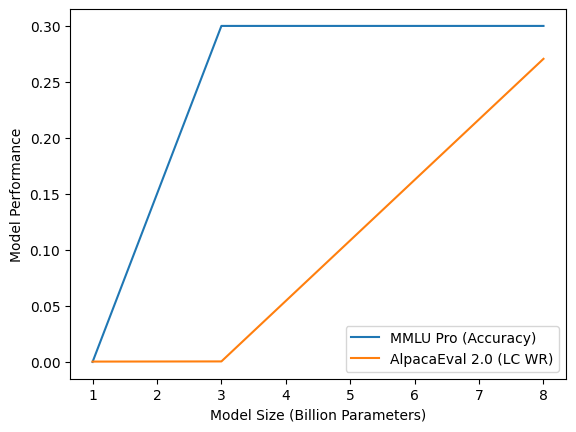

In [9]:
import matplotlib.pyplot as plt

# Data
model_sizes = [1, 3, 8]
plt.plot(model_sizes, mmlu_acc, label="MMLU Pro (Accuracy)")
plt.plot(model_sizes, alpaca_lcwr, label="AlpacaEval 2.0 (LC WR)")

# Show
plt.xlabel("Model Size (Billion Parameters)")
plt.ylabel("Model Performance")
plt.legend()
plt.show()